# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** RISNA DWI INDRIANI
- **Email:** mc009d5x2320@student.devacademy.id
- **ID Dicoding:** mc009d5x2320

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns


## Data Preparation

### Data Loading

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"risnadwiindriani","key":"3e70e6c9730fa87aabfca6efa992dcb8"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d misrakahmed/vegetable-image-dataset
!unzip vegetable-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Vegetable Images/train/Radish/0001.jpg  
  inflating: Vegetable Images/train/Radish/0002.jpg  
  inflating: Vegetable Images/train/Radish/0003.jpg  
  inflating: Vegetable Images/train/Radish/0004.jpg  
  inflating: Vegetable Images/train/Radish/0005.jpg  
  inflating: Vegetable Images/train/Radish/0006.jpg  
  inflating: Vegetable Images/train/Radish/0007.jpg  
  inflating: Vegetable Images/train/Radish/0008.jpg  
  inflating: Vegetable Images/train/Radish/0009.jpg  
  inflating: Vegetable Images/train/Radish/0010.jpg  
  inflating: Vegetable Images/train/Radish/0011.jpg  
  inflating: Vegetable Images/train/Radish/0012.jpg  
  inflating: Vegetable Images/train/Radish/0013.jpg  
  inflating: Vegetable Images/train/Radish/0014.jpg  
  inflating: Vegetable Images/train/Radish/0015.jpg  
  inflating: Vegetable Images/train/Radish/0016.jpg  
  inflating: Vegetable Images/train/Radish/0017.jpg  
  inflating: Vegetable Images/t

- Data Preparation

In [4]:
# Direktori awal untuk train dan test
train_dir = "Vegetable Images/train"
test_dir = "Vegetable Images/test"

# Direktori baru untuk dataset gabungan
combined_dir = "Vegetable Images/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

- Dataset Checking

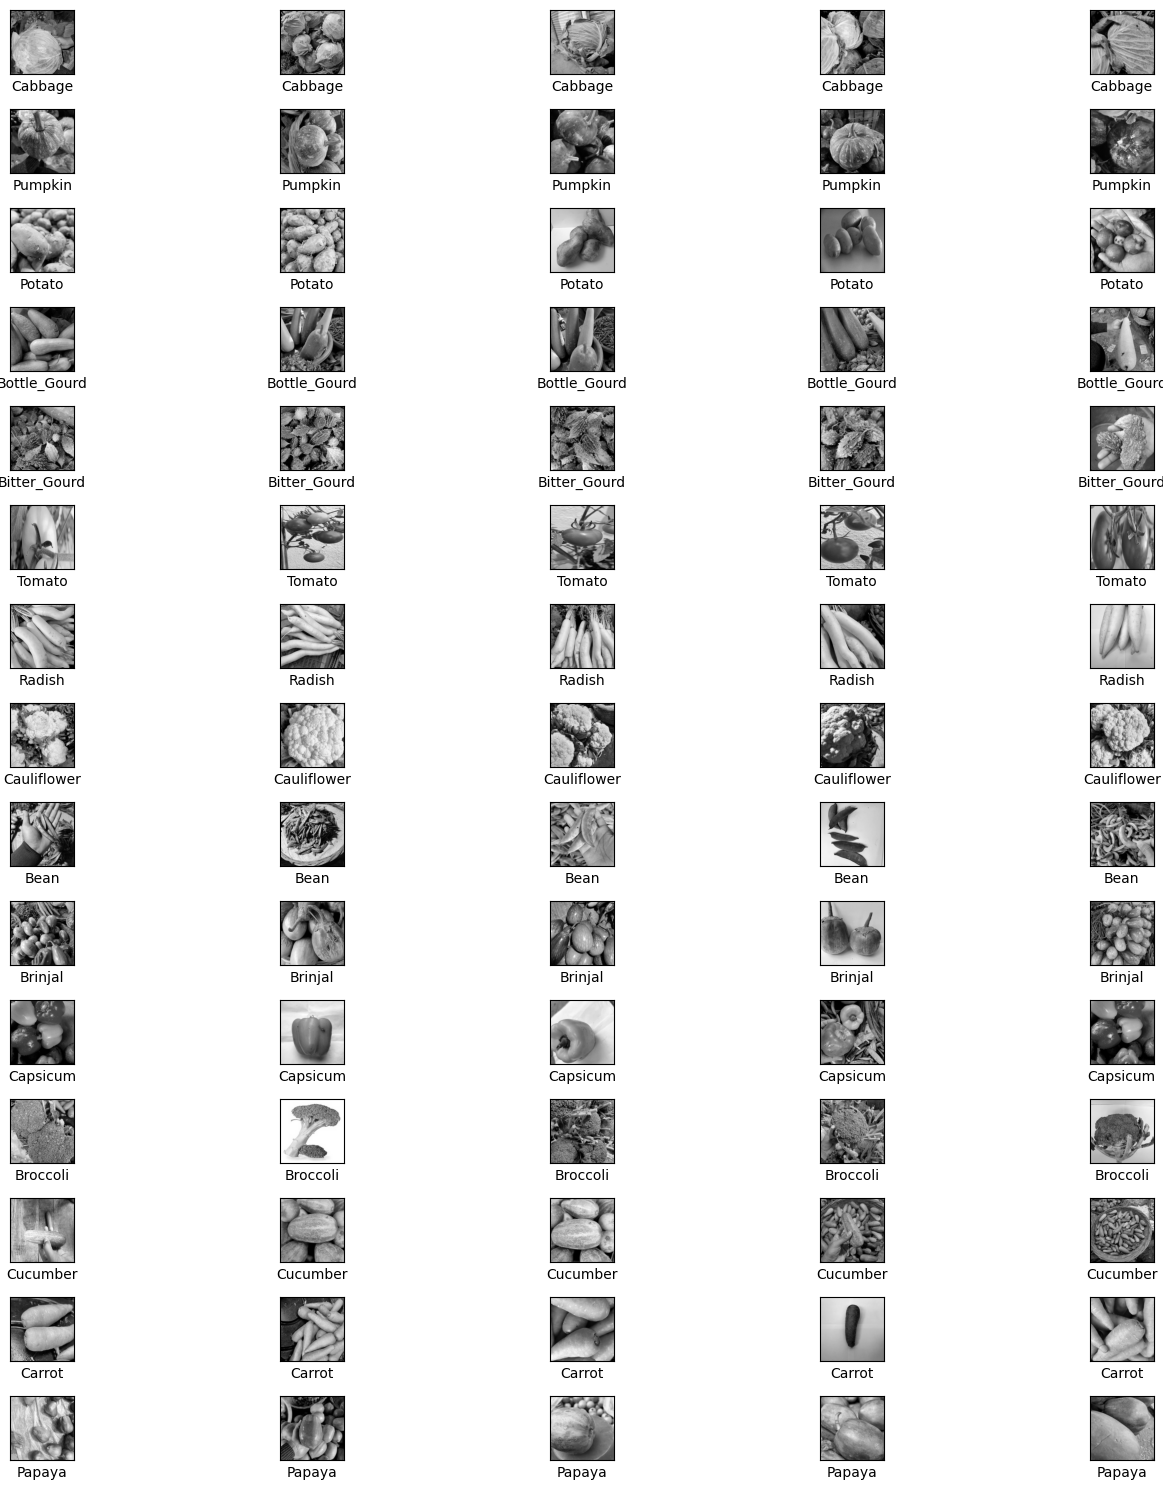

In [5]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# path sumber train
path = "Vegetable Images/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
path_sub = "Vegetable Images/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

- plot distribusi

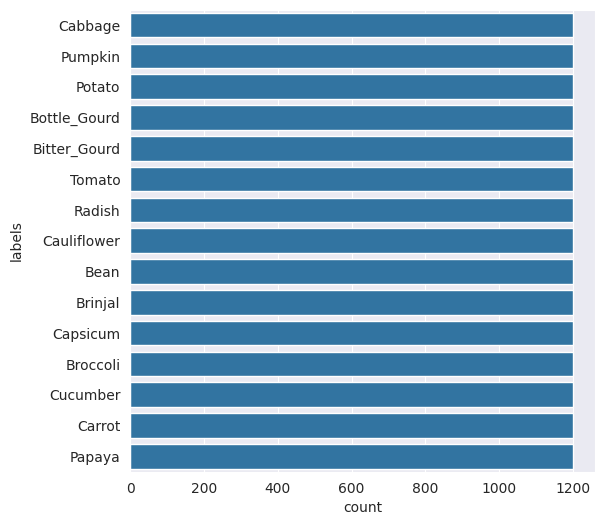

In [6]:
# Definisikan path sumber
lung_path = "Vegetable Images/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [7]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath = 'Vegetable Images/dataset/'

file_name = []
labels = []
full_path = []

# Mengumpulkan path file, nama file, dan label
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Membuat DataFrame dari data yang terkumpul
df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Split ke Train, Val, Test
X = df['path']
y = df['labels']

# Tahap 1: train 70%, sisanya 30% (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=300, stratify=y)

# Tahap 2: val 15%, test 15% dari data awal
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=300, stratify=y_temp)

# Buat dataframe masing-masing
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'val'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

# Gabungkan semuanya
df_all = pd.concat([df_tr, df_val, df_te], ignore_index=True)

# Cek distribusi label per set
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Persiapan untuk menyalin file
datasource_path = "Vegetable Images/dataset/"
dataset_path = "Dataset-Final/"

# Salin file ke folder baru sesuai set dan label
for index, row in tq(df_all.iterrows(), total=len(df_all)):
    file_path = row['path']

    # Buat folder tujuan jika belum ada
    dest_dir = os.path.join(dataset_path, row['set'], row['labels'])
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # Tentukan path file tujuan
    dest_file = os.path.join(dest_dir, os.path.basename(file_path))

    # Salin file
    if not os.path.exists(dest_file):
        shutil.copy2(file_path, dest_file)



set    labels      
test   Bean            180
       Bitter_Gourd    180
       Bottle_Gourd    180
       Brinjal         180
       Broccoli        180
       Cabbage         180
       Capsicum        180
       Carrot          180
       Cauliflower     180
       Cucumber        180
       Papaya          180
       Potato          180
       Pumpkin         180
       Radish          180
       Tomato          180
train  Bean            840
       Bitter_Gourd    840
       Bottle_Gourd    840
       Brinjal         840
       Broccoli        840
       Cabbage         840
       Capsicum        840
       Carrot          840
       Cauliflower     840
       Cucumber        840
       Papaya          840
       Potato          840
       Pumpkin         840
       Radish          840
       Tomato          840
val    Bean            180
       Bitter_Gourd    180
       Bottle_Gourd    180
       Brinjal         180
       Broccoli        180
       Cabbage         180
       

  0%|          | 0/18000 [00:00<?, ?it/s]

In [8]:
print("Train size :", len(df_tr))
print("Val size :", len(df_val))
print("Test size :", len(df_te))

Train size : 12600
Val size : 2700
Test size : 2700


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.5, 1),
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_tr,
    x_col='path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_datagen.flow_from_dataframe(
    dataframe=df_te,
    x_col='path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=False
)

Found 12600 validated image filenames belonging to 15 classes.
Found 2700 validated image filenames belonging to 15 classes.
Found 2700 validated image filenames belonging to 15 classes.


In [11]:
print("Distribusi Train:")
print(df_tr['labels'].value_counts())

print("\nDistribusi Validation:")
print(df_val['labels'].value_counts())

print("\nDistribusi Test:")
print(df_te['labels'].value_counts())

Distribusi Train:
labels
Pumpkin         840
Radish          840
Bean            840
Cabbage         840
Bottle_Gourd    840
Carrot          840
Brinjal         840
Cauliflower     840
Capsicum        840
Cucumber        840
Potato          840
Broccoli        840
Papaya          840
Bitter_Gourd    840
Tomato          840
Name: count, dtype: int64

Distribusi Validation:
labels
Radish          180
Capsicum        180
Cucumber        180
Brinjal         180
Carrot          180
Bottle_Gourd    180
Papaya          180
Tomato          180
Bean            180
Cabbage         180
Pumpkin         180
Cauliflower     180
Potato          180
Bitter_Gourd    180
Broccoli        180
Name: count, dtype: int64

Distribusi Test:
labels
Bitter_Gourd    180
Cucumber        180
Brinjal         180
Cauliflower     180
Tomato          180
Bean            180
Capsicum        180
Papaya          180
Broccoli        180
Carrot          180
Bottle_Gourd    180
Potato          180
Radish          180
Pumpkin

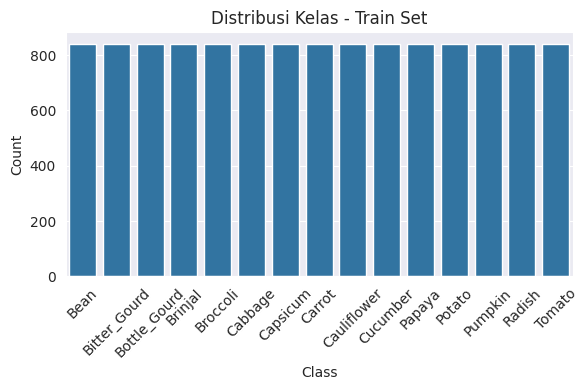

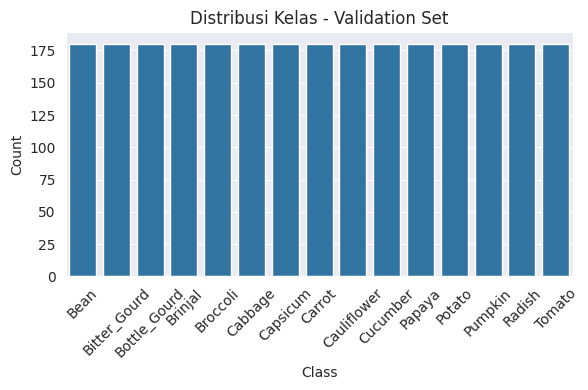

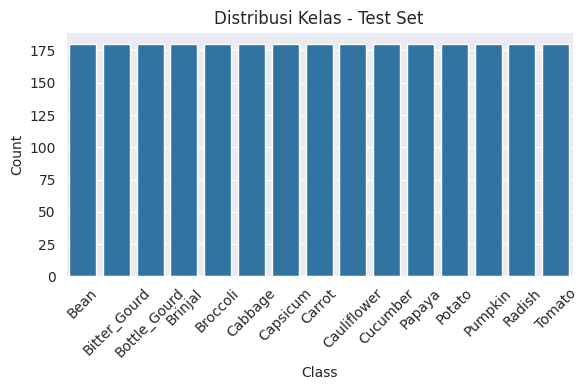

In [12]:
def plot_class_distribution(df, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x='labels', order=sorted(df['labels'].unique()))
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)  # Supaya label nggak nabrak
    plt.tight_layout()
    plt.show()

# Plot distribusi
plot_class_distribution(df_tr, "Distribusi Kelas - Train Set")
plot_class_distribution(df_val, "Distribusi Kelas - Validation Set")
plot_class_distribution(df_te, "Distribusi Kelas - Test Set")

## Modelling

In [13]:
# Load base model MobileNetV2
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Bangun model
model = Sequential([
    base_model,

    # Tambahan Conv2D dan Pooling sebelum pooling global
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(15, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,632,815 (10.04 MB)

 Trainable params: 374,831 (1.43 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [17]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 192s 115ms/step - accuracy: 0.4159 - loss: 1.7179 - val_accuracy: 0.9344 - val_loss: 0.2905 - learning_rate: 0.0010
Epoch 2/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 174s 111ms/step - accuracy: 0.6708 - loss: 0.9509 - val_accuracy: 0.9630 - val_loss: 0.1742 - learning_rate: 0.0010
Epoch 3/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 174s 110ms/step - accuracy: 0.7522 - loss: 0.7453 - val_accuracy: 0.9793 - val_loss: 0.0734 - learning_rate: 0.0010
Epoch 4/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 174s 110ms/step - accuracy: 0.7894 - loss: 0.6240 - val_accuracy: 0.9789 - val_loss: 0.0668 - learning_rate: 0.0010
Epoch 5/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 175s 111ms/step - accuracy: 0.8012 - loss: 0.6002 - val_accuracy: 0.9752 - val_loss: 0.0679 - learning_rate: 0.0010
Epoch 6/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 174s 111ms/step - accuracy: 0.8343 - loss: 0.5263 - val_accuracy: 0.9804 - val_loss: 0.0649 - learning_rate: 0.0010
Epoch 7/25
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 174s 110ms

## Evaluasi dan Visualisasi

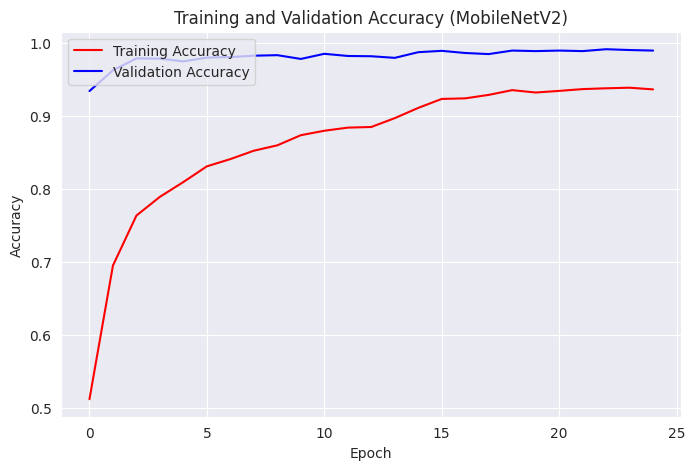

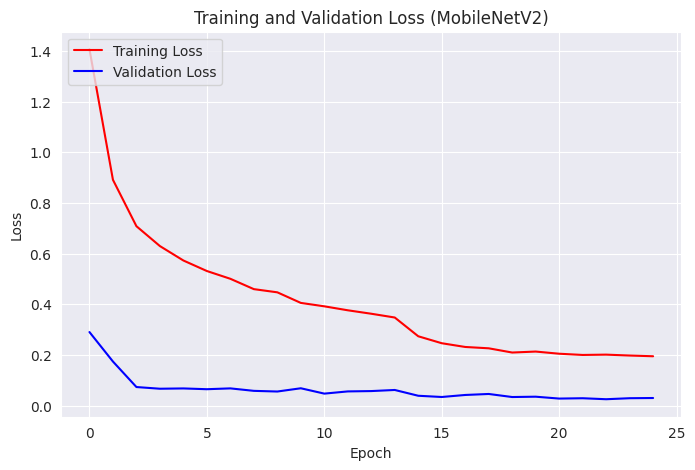

In [18]:
# Mengambil akurasi dan loss dari history training model MobileNet
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Menentukan jumlah epoch
epochs = range(len(acc))

# Plot grafik akurasi
plt.figure(figsize=(8,5))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy (MobileNetV2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot grafik loss
plt.figure(figsize=(8,5))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss (MobileNetV2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

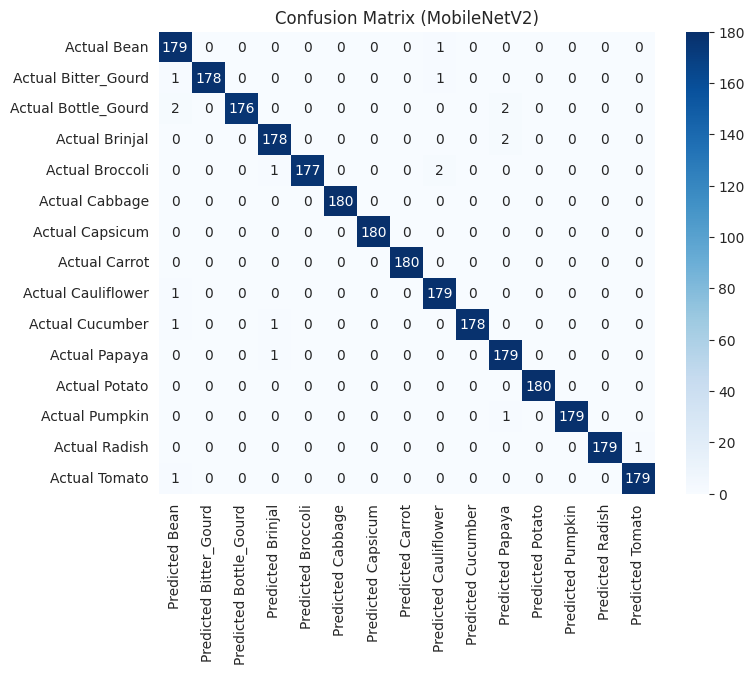


Classification Report (MobileNetV2):

              precision    recall  f1-score   support

        Bean     0.9676    0.9944    0.9808       180
Bitter_Gourd     1.0000    0.9889    0.9944       180
Bottle_Gourd     1.0000    0.9778    0.9888       180
     Brinjal     0.9834    0.9889    0.9861       180
    Broccoli     1.0000    0.9833    0.9916       180
     Cabbage     1.0000    1.0000    1.0000       180
    Capsicum     1.0000    1.0000    1.0000       180
      Carrot     1.0000    1.0000    1.0000       180
 Cauliflower     0.9781    0.9944    0.9862       180
    Cucumber     1.0000    0.9889    0.9944       180
      Papaya     0.9728    0.9944    0.9835       180
      Potato     1.0000    1.0000    1.0000       180
     Pumpkin     1.0000    0.9944    0.9972       180
      Radish     1.0000    0.9944    0.9972       180
      Tomato     0.9944    0.9944    0.9944       180

    accuracy                         0.9930      2700
   macro avg     0.9931    0.9930    0.99

In [19]:
# Reset test generator untuk menghindari duplikasi data
test_generator.reset()

# Melakukan prediksi menggunakan MobileNetV2
preds_mobilenet = model.predict(test_generator, verbose=0)

# Mengambil label prediksi dengan nilai probabilitas tertinggi
y_pred = np.argmax(preds_mobilenet, axis=1)

# Label asli (tersedia di test_generator.classes)
y_true = test_generator.classes

# Daftar nama kelas dari test_generator
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = pd.DataFrame(
    data=confusion_matrix(y_true, y_pred),
    index=[f"Actual {label}" for label in class_labels],
    columns=[f"Predicted {label}" for label in class_labels]
)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (MobileNetV2)")
plt.show()

# Classification Report
print("\nClassification Report (MobileNetV2):\n")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))

## Konversi Model

- SaveModel

In [20]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

- TF-Lite

In [21]:
# Tentukan direktori SavedModel
saved_model_dir = 'saved_model/'

# Mengonversi model ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Menyimpan model dalam format TFLite
tflite_model_path = 'model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Class label
class_labels = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

# Simpan label ke label.txt
with open('label.txt', 'w') as f:
    for label in class_labels:
        f.write(f"{label}\n")

- TFJS

In [27]:
!pip install tensorflowjs
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    saved_model \
    tfjs_model

2025-04-24 06:17:43.022202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745475463.041943   21936 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745475463.047934   21936 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-24 06:17:47.211496: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745475467.211669   21936 gpu_device.cc:2022] Created device /job:localhost/replica:0/task